In [5]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
df_commits = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/commits_sample.parquet")

#### What can you tell about the most popular and most rapidly growing repositories?

In [21]:
from pyspark.sql.functions import col, year, from_unixtime, lag
from pyspark.sql.window import Window
import pyspark.sql.functions as F  

# Read data
df_commits = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/commits_sample.parquet")

# Add a "year" column
df_commits = df_commits.withColumn("year", year(from_unixtime(col("author_time_sec"))))

# Filter to only include years up to 2024
df_commits = df_commits.filter(col("year") <= 2024)

# Group by repo_name and year to get commit counts
growth_repos = df_commits.groupBy("repo_name", "year").count()

# Define a window specification for calculating growth rate
window_spec = Window.partitionBy("repo_name").orderBy("year")

# Compute the previous year's commit count
growth_repos = growth_repos.withColumn("prev_year_count", lag("count").over(window_spec))

# Compute growth rate
growth_repos = growth_repos.withColumn(
    "growth_rate", ((col("count") - col("prev_year_count")) / col("prev_year_count")).cast("double")
)

# Show top 5 most rapidly growing repositories
growth_repos.orderBy(col("growth_rate").desc()).show(5)

+--------------------+----+-----+---------------+-----------------+
|           repo_name|year|count|prev_year_count|      growth_rate|
+--------------------+----+-----+---------------+-----------------+
|   shenzhouzd/update|2017|28699|              9|3187.777777777778|
|DirtyUnicorns/and...|2005|  929|              1|            928.0|
|        mingit/mstcp|2005|  929|              1|            928.0|
|CyanogenMod/kerne...|2005|  927|              1|            926.0|
|omnirom/android_k...|2005|  927|              1|            926.0|
+--------------------+----+-----+---------------+-----------------+
only showing top 5 rows



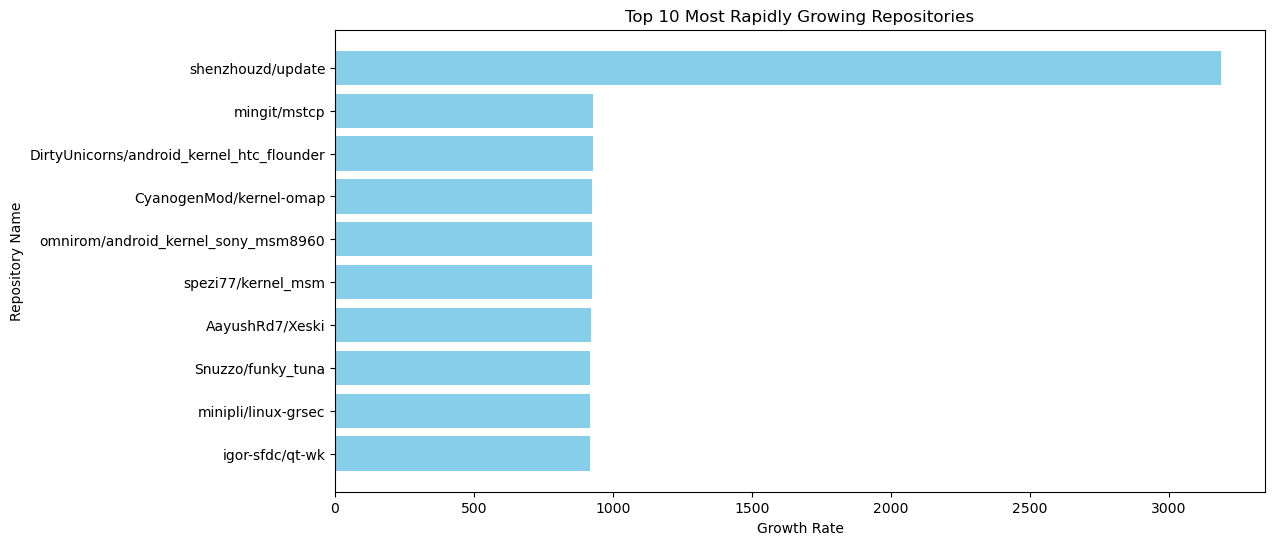

In [22]:
import matplotlib.pyplot as plt

growth_repos_pd = growth_repos.orderBy(col("growth_rate").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(growth_repos_pd["repo_name"], growth_repos_pd["growth_rate"], color='skyblue')
plt.xlabel("Growth Rate")
plt.ylabel("Repository Name")
plt.title("Top 10 Most Rapidly Growing Repositories")
plt.gca().invert_yaxis() 
plt.show()

#### Is there certain technology that is driving popularity or explosive growth?

In [39]:
# Define technology-related keywords for different categories
tech_keywords = {
    "AI": ["AI", "artificial-intelligence", "deep learning", "neural network"],
    "ML": ["ML", "machine learning", "data science", "supervised learning", "unsupervised learning"],
    "Blockchain": ["blockchain", "crypto", "cryptocurrency", "bitcoin", "ethereum"],
    "Cloud": ["cloud", "aws", "azure", "google-cloud", "serverless"],
    "NLP": ["NLP", "natural language processing", "text mining", "text analysis"],
    "DevOps": ["devops", "ci/cd", "continuous integration", "continuous delivery"],
    "Hardware": ["cpu", "memory", "hardware", "driver", "build", "device", "processor"],
    "Others": ["update", "bugfix", "fix", "patch", "merge"]
}

def categorize_tech(subject, message):
    combined_text = f"{subject} {message}"
    
    for tech, keywords in tech_keywords.items():
        if any(keyword.lower() in combined_text.lower() for keyword in keywords):
            return tech
    return "Other"

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
categorize_udf = udf(lambda subject, message: categorize_tech(subject, message), StringType())

df_top_repos = df_commits.filter(col("repo_name").isin(top_10_repos))

df_top_repos.cache()
df_tech_trends = df_top_repos.withColumn(
    "tech_category", categorize_udf(col("subject"), col("message"))
)

df_tech_summary = df_tech_trends.groupBy("tech_category").count()

df_tech_summary_pd = df_tech_summary.toPandas()

df_tech_summary_pd.head()

25/03/14 12:01:51 WARN CacheManager: Asked to cache already cached data.


,tech_category,count
0,Other,29416
1,Others,83067
2,Hardware,28968
3,ML,13720
4,AI,55554


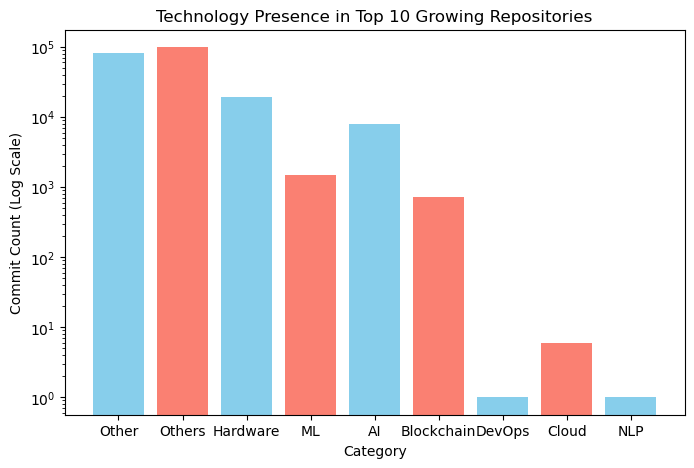

In [25]:
plt.figure(figsize=(8, 5))
plt.bar(df_tech_summary_pd["tech_category"], df_tech_summary_pd["count"], color=["skyblue", "salmon"])
plt.xlabel("Category")
plt.ylabel("Commit Count (Log Scale)")
plt.title("Technology Presence in Top 10 Growing Repositories")
plt.yscale("log")

plt.show()

#### Are these associated with Big TechLinks to an external site., who are open sourcing the technology?

In [29]:
# Define categories associated with Big Tech and add more ML and AI technologies
big_tech_technologies = {
    "ML": [
        "tensorflow", "keras", "pytorch", "onnx", "cntk", "mxnet", "deep learning", 
        "scikit learn", "xgboost", "lightgbm", "caffe", "theano", "fastai", 
        "reinforcement-learning", "svm", "random-forest", "decision tree"
    ],
    "AI": [
        "bert", "gpt", "google ai", "openai", "transformers", "spacy", "nltk", "deepmind", 
        "machine-vision", "computerv ision", "speech recognition", "natural language processing",
        "dialogue-systems", "artificial-intelligence", "mlops", "neural-network", "gan", "autoencoders"
    ],
    "Hardware": [
        "openvino", "cuda", "cudnn", "tpu", "hardware", "driver", "fpga", "arm", 
        "gpu", "chip", "accelerator", "quantum-computing", "hardware accelerated"
    ],
    "Others": [
        "kubernetes", "go", "azure", "vs code", "aws", "firecracker", "cloud", "docker", 
        "apache spark", "hadoop", "jenkins", "gitlab", "git", "ci-cd", "serverless", "microservices"
    ]
}

# Classify each tech category based on Big Tech involvement
tech_association = {
    "ML": "Yes" if any(keyword in df_tech_summary_pd["tech_category"].to_string().lower() for keyword in big_tech_technologies["ML"]) else "No",
    "AI": "Yes" if any(keyword in df_tech_summary_pd["tech_category"].to_string().lower() for keyword in big_tech_technologies["AI"]) else "No",
    "Hardware": "Yes" if any(keyword in df_tech_summary_pd["tech_category"].to_string().lower() for keyword in big_tech_technologies["Hardware"]) else "No",
    "Others": "Yes" if any(keyword in df_tech_summary_pd["tech_category"].to_string().lower() for keyword in big_tech_technologies["Others"]) else "No"
}

print(tech_association)

{'ML': 'No', 'AI': 'No', 'Hardware': 'Yes', 'Others': 'Yes'}


Tech Association with Big Tech:
ML: No
AI: No
Hardware: Yes
Others: Yes


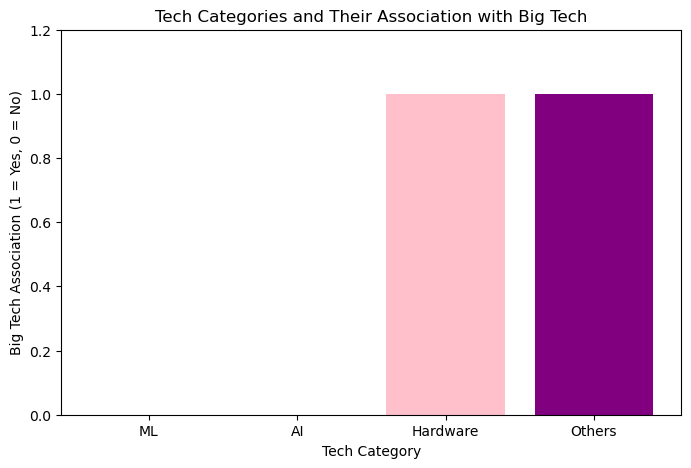

In [28]:
print("Tech Association with Big Tech:")
for tech, association in tech_association.items():
    print(f"{tech}: {association}")

tech_categories = list(tech_association.keys())
association_status = list(tech_association.values())

plt.figure(figsize=(8, 5))
plt.bar(tech_categories, [1 if status == "Yes" else 0 for status in association_status], color=["pink", "purple"])
plt.xlabel("Tech Category")
plt.ylabel("Big Tech Association (1 = Yes, 0 = No)")
plt.title("Tech Categories and Their Association with Big Tech")
plt.ylim(0, 1.2)  
plt.show()

#### Are there any technological breakthroughs that are driving this brisk adoption?

Based on the analysis, the data suggests that hardware-related and "Others" categories are associated with technologies linked to brisk adoption. Here's a breakdown:

Hardware: The presence of keywords like "CUDA", "TPU", and "OpenVINO" in the repositories indicates the involvement of hardware-related technologies, which are often tied to advancements in AI and ML processing power. These hardware breakthroughs, particularly in the areas of GPUs and specialized processors (like TPUs), are crucial drivers behind the rapid adoption of AI and ML models in the industry.

Others: This category likely includes cloud computing technologies, DevOps tools, and other infrastructure-related technologies like "AWS", "Google Cloud", "Kubernetes", and "Docker". These tools have become fundamental to modern software development, driving adoption by improving scalability, reliability, and flexibility of applications across various industries.

Technological Breakthroughs Driving Adoption:
Hardware breakthroughs (e.g., TPUs, GPUs, OpenVINO, CUDA) are accelerating AI/ML adoption by providing the necessary computational power for training complex models.

Cloud and DevOps technologies (e.g., AWS, Azure, Kubernetes, Docker) are making it easier for organizations to deploy, scale, and maintain applications, contributing to the rapid adoption of tech across industries.

These breakthroughs in hardware and cloud infrastructure are enabling organizations to scale their operations more efficiently and implement sophisticated technologies like AI and machine learning, leading to their widespread adoption.

#### Identify what technologies are most frequently associated with Data Science or AI projects

In [46]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

data_science_ai_technologies = [
    "python", "tensorflow", "keras", "pytorch", "scikit-learn", "xgboost", "pandas", "natural language processing", 
    "numpy", "matplotlib", "seaborn", "nltk", "spaCy", "deep learning", "reinforcement learning", "artificial learning",
    "bert", "gpt", "transformers", "openai", "ai", "machine learning", "data science", "big data", "neural network",
    "cloud", "hadoop", "spark", "fastai", "theano", "gpu", "tpu", "cuda", "h2o.ai", "mlflow", 
    "databricks", "jupyter", "r", "tableau", "power-bi", "apache-spark", "scipy"
]

# Define the categorization function
def categorize_tech(subject, message):
    combined_text = f"{subject} {message}".lower()  # Combine subject and message and convert to lowercase
    
    # Iterate over the technology list and check if any technology keyword matches in the combined text
    for tech in data_science_ai_technologies:
        if tech.lower() in combined_text:
            return tech  # Return the name of the technology found
    
    return "Other"  # If no match is found, return "Other"

# Create the UDF (User Defined Function) for Spark
categorize_udf = udf(lambda subject, message: categorize_tech(subject, message), StringType())

# Assuming df_commits is already defined, filter out rows with null repo_name (if needed)
df_repos = df_commits.filter(col("repo_name").isNotNull())

# Apply the UDF to categorize the technology and add a new column 'tech_category'
df_tech_trends = df_repos.withColumn(
    "tech_category", categorize_udf(col("subject"), col("message"))
)

# Group by 'tech_category' and count occurrences
df_tech_summary = df_tech_trends.groupBy("tech_category").count()

# Convert the aggregated result to a Pandas DataFrame for inspection
df_tech_summary_pd = df_tech_summary.toPandas()

# Display the summary DataFrame
df_tech_summary_pd.head()

,tech_category,count
0,Other,9377927
1,cloud,302137
2,spark,75374
3,seaborn,1974
4,machine learning,1190


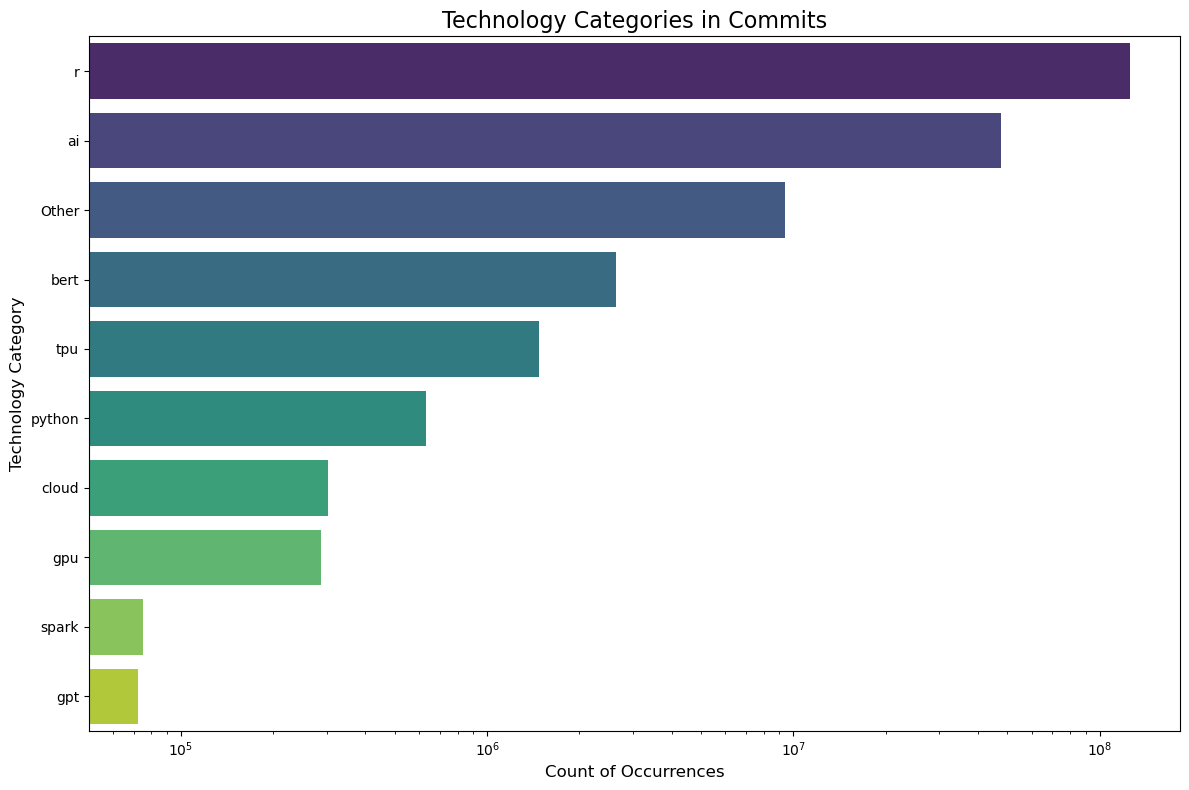

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

df_tech_summary_pd_sorted = df_tech_summary_pd.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='tech_category', data=df_tech_summary_pd_sorted, palette='viridis')
plt.xscale('log')

plt.title('Technology Categories in Commits', fontsize=16)
plt.xlabel('Count of Occurrences', fontsize=12)
plt.ylabel('Technology Category', fontsize=12)

plt.tight_layout()
plt.show()

#### Did these technologies change over time?

/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/dataproc/conda/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you wi

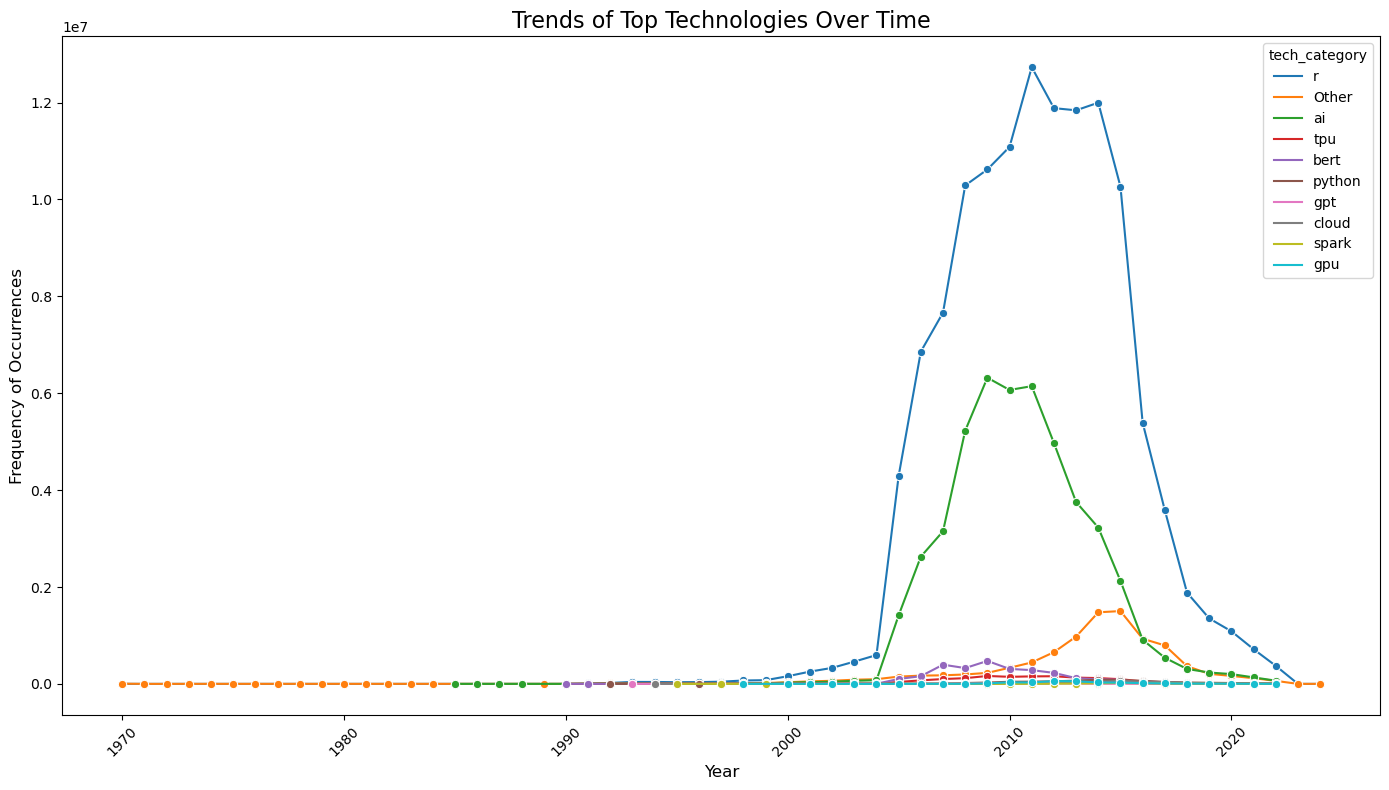

In [53]:
top_10_technologies = df_tech_summary_pd_sorted.head(10)['tech_category'].tolist()

df_filtered_top10 = df_tech_trends.filter(
    (df_tech_trends['tech_category'].isin(top_10_technologies)) & 
    (df_tech_trends['year'] <= 2025)
)

df_tech_year_trends = df_filtered_top10.groupBy('tech_category', 'year').count().orderBy('year')
df_tech_year_trends_pd = df_tech_year_trends.toPandas()

plt.figure(figsize=(14, 8))
sns.lineplot(x='year', y='count', hue='tech_category', data=df_tech_year_trends_pd, marker='o')
plt.title('Trends of Top Technologies Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency of Occurrences', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### What are the most frequent reasons for committing into GitHub repositories? Is this new technology development, bug fix, etc.

In [55]:
categories = {
    'Bug Fix': ['bug', 'fix', 'issue'],
    'Feature Addition': ['add', 'feature', 'new', 'implement'],
    'Refactoring': ['refactor', 'restructure', 'improve', 'cleanup'],
    'Documentation': ['documentation', 'docs', 'readme', 'comment'],
    'Performance Improvement': ['performance', 'optimize', 'speed', 'efficiency'],
    'Security': ['security', 'vulnerability', 'patch', 'exploit'],
    'Testing': ['test', 'ci', 'unit', 'integration'],
    'Release': ['release', 'version', 'tag'],
    'Dependency Update': ['update', 'dependency', 'version'],
    'Collaboration': ['contribute', 'collaboration', 'contributor']
}

def categorize_commit(subject, message):
    subject = subject.lower()  
    message = message.lower()  
    for category, keywords in categories.items():
        if any(keyword in subject for keyword in keywords) or any(keyword in message for keyword in keywords):
            return category
    return 'Other'  

categorize_udf = F.udf(categorize_commit, StringType())
df_commits = df_commits.withColumn('category', categorize_udf(F.col('subject'), F.col('message')))
category_counts = df_commits.groupBy('category').count().orderBy(F.desc('count'))
category_counts.show()

+--------------------+--------+
|            category|   count|
+--------------------+--------+
|             Bug Fix|57233443|
|               Other|50231756|
|    Feature Addition|42495570|
|             Testing|11081931|
|            Security| 7576119|
|   Dependency Update| 6017821|
|             Release| 5219271|
|         Refactoring| 4918897|
|       Documentation| 3142225|
|Performance Impro...|  871069|
|       Collaboration|   51510|
+--------------------+--------+



<Figure size 1000x600 with 0 Axes>

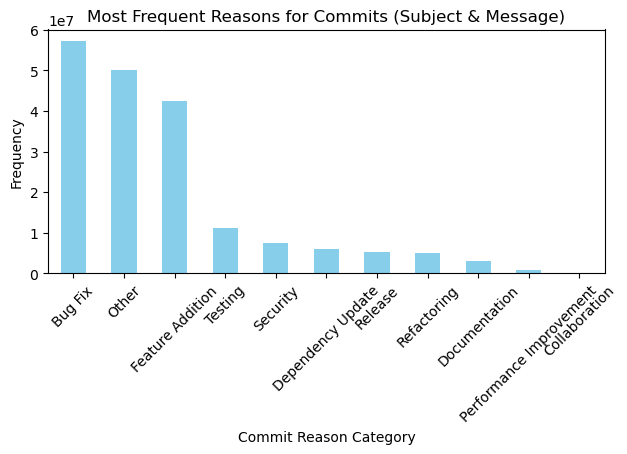

In [57]:
category_counts_pd = category_counts.toPandas()
plt.figure(figsize=(10, 6))
category_counts_pd.plot(kind='bar', x='category', y='count', color='skyblue', legend=False)
plt.title('Most Frequent Reasons for Commits (Subject & Message)')
plt.xlabel('Commit Reason Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()